## NON LINEAR MODELLING

In [110]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize,
                         poly,
                         ModelSpec as MS)
from statsmodels.stats.anova import anova_lm

from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)

from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)

In [111]:
import numpy as np
import matplotlib.pyplot as plt

def plot_range_fit(data, 
                   y, 
                   basis, 
                   model, 
                   title):
    # Genera un range uniforme per il plot
    range_grid = np.linspace(data['range'].min(), data['range'].max(), 100)
    df_range = pd.DataFrame({'range': range_grid})
    
    # Applica la trasformazione spline
    Xnew = basis.transform(df_range)
    
    # Predizione e bande
    preds = model.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(data['range'], y, facecolor='gray', alpha=0.5, label='Dati')
    ax.plot(range_grid, preds.predicted_mean, 'b', linewidth=2, label='Fit')
    ax.plot(range_grid, bands[:, 0], 'r--', linewidth=1.5, label='95% CI')
    ax.plot(range_grid, bands[:, 1], 'r--', linewidth=1.5)
    
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Range', fontsize=14)
    ax.set_ylabel('log-Price', fontsize=14)
    ax.legend()
    plt.show()


## Splines

In [112]:
data=pd.read_csv("Data/aircraft_price_Engineered.csv")
data.columns

Index(['price', 'roc_mean', 'speed_margin', 'power_per_distance', 'wing_span',
       'range'],
      dtype='object')

In [113]:
price = data['price']
y = price
range = data['range']

In [114]:
lower_bound = range.min()
upper_bound = range.max()
print(f"Range: {lower_bound} to {upper_bound}")

Range: 117.0 to 6500.0


In [115]:
bs_ = BSpline(internal_knots=[1000,2500,4500], intercept=True).fit(data['range'])
bs_age = bs_.transform(data['range'])
bs_age.shape

(507, 7)

In [116]:
bs_range = MS([bs('range', internal_knots=[1000,2500,4500])])
Xbs = bs_range.fit_transform(data)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,13.8945,0.065,213.401,0.000
"bs(range, internal_knots=[1000, 2500, 4500])[0]",0.3661,0.101,3.642,0.000
"bs(range, internal_knots=[1000, 2500, 4500])[1]",1.1966,0.076,15.766,0.000
"bs(range, internal_knots=[1000, 2500, 4500])[2]",1.3741,0.178,7.708,0.000
"bs(range, internal_knots=[1000, 2500, 4500])[3]",1.4682,0.425,3.456,0.001
"bs(range, internal_knots=[1000, 2500, 4500])[4]",1.0763,1.434,0.751,0.453
"bs(range, internal_knots=[1000, 2500, 4500])[5]",1.5502,0.256,6.067,0.000


In [117]:
bs_range = MS([bs('range',
                internal_knots=[1000,2500,4500],
                name='bs(range)')])
Xbs = bs_range.fit_transform(data)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,13.8945,0.065,213.401,0.000
bs(range)[0],0.3661,0.101,3.642,0.000
bs(range)[1],1.1966,0.076,15.766,0.000
bs(range)[2],1.3741,0.178,7.708,0.000
bs(range)[3],1.4682,0.425,3.456,0.001
bs(range)[4],1.0763,1.434,0.751,0.453
bs(range)[5],1.5502,0.256,6.067,0.000


### alternative method

In [118]:
BSpline(df=6).fit(range).internal_knots_

array([ 520.,  713., 1100.])

In [119]:
bs_range = MS([bs('range',
                 df=3, 
                 degree=3)]).fit(data)
Xbs0 = bs_range.transform(data)
# Trasformazione e fit
Xbs0 = bs_range.transform(data)
model = sm.OLS(y, Xbs0).fit()
print(summarize(model))




                                 coef  std err        t  P>|t|
intercept                     13.9068    0.031  451.558  0.000
bs(range, df=3, degree=3)[0]   2.6864    0.149   18.083  0.000
bs(range, df=3, degree=3)[1]   0.4231    0.235    1.800  0.072
bs(range, df=3, degree=3)[2]   1.6193    0.246    6.570  0.000


In [120]:
#ANOVA

X0 = np.ones((len(y), 1))
model0 = sm.OLS(y, X0).fit()
model1 = sm.OLS(y, Xbs0).fit()

anova_results = anova_lm(model0, model1)
print(anova_results)

   df_resid        ssr  df_diff    ss_diff           F         Pr(>F)
0     506.0  86.195167      0.0        NaN         NaN            NaN
1     503.0  30.665882      3.0  55.529285  303.608102  1.897836e-112


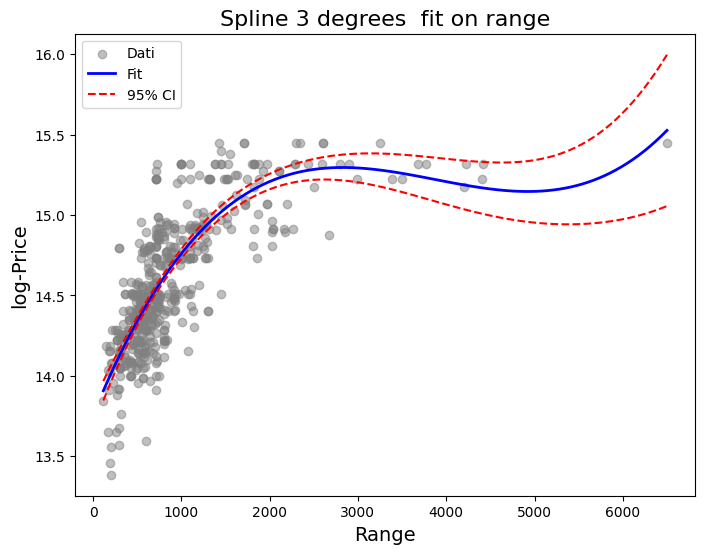

In [121]:
# Solo plot
plot_range_fit(data, y, bs_range, model, "Spline 3 degrees  fit on range")

## Smothing Splines and GAMs

In [122]:
range_grid = np.linspace(range.min(),
                       range.max(),
                       100)
range_df = pd.DataFrame({'range': range_grid})

In [123]:

def plot_range_fit(data, 
                   basis, 
                   y, 
                   title):
    # Costruzione della matrice X e Xnew
    X = basis.transform(data)

    # Griglia di valori per il range
    range_grid = np.linspace(data['range'].min(), data['range'].max(), 100)
    range_df = pd.DataFrame({'range': range_grid})
    Xnew = basis.transform(range_df)

    # Fit del modello e predizioni sulla griglia
    model = sm.OLS(y, X).fit()
    preds = model.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)

    # Plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(data['range'], y, facecolor='gray', alpha=0.5, label='Dati')
    ax.plot(range_df['range'], preds.predicted_mean, 'b', linewidth=3, label='Fit')
    ax.plot(range_df['range'], bands[:, 0], 'r--', linewidth=2, label='95% CI')
    ax.plot(range_df['range'], bands[:, 1], 'r--', linewidth=2)

    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Range', fontsize=20)
    ax.set_ylabel('Target (y)', fontsize=20)
    ax.legend()
    return ax


In [124]:
X_range = np.asarray(range).reshape((-1,1))
gam = LinearGAM(s_gam(0, lam=0.6))
gam.fit(X_range, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\l'
/var/folders/r4/hh357kg10tl7tyxysctqkm100000gn/T/ipykernel_76719/2774907423.py:11: SyntaxWarning: invalid escape sequence '\l'
  ax.legend(title='$\lambda$');


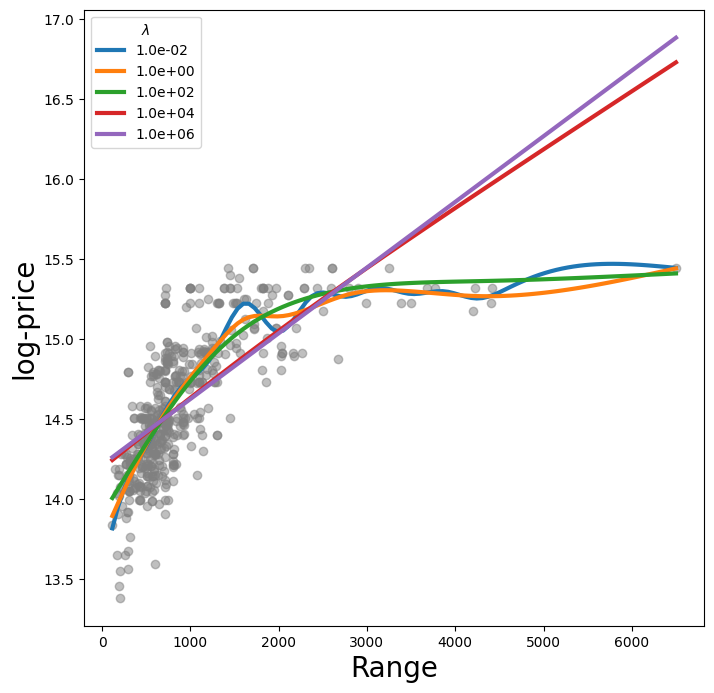

In [125]:
fig, ax = subplots(figsize=(8,8))
ax.scatter(range, y, facecolor='gray', alpha=0.5)
for lam in np.logspace(-2, 6, 5):
    gam = LinearGAM(s_gam(0, lam=lam)).fit(X_range, y)
    ax.plot(range_grid,
            gam.predict(range_grid),
            label='{:.1e}'.format(lam),
            linewidth=3)
ax.set_xlabel('Range', fontsize=20)
ax.set_ylabel('log-price', fontsize=20);
ax.legend(title='$\lambda$');

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


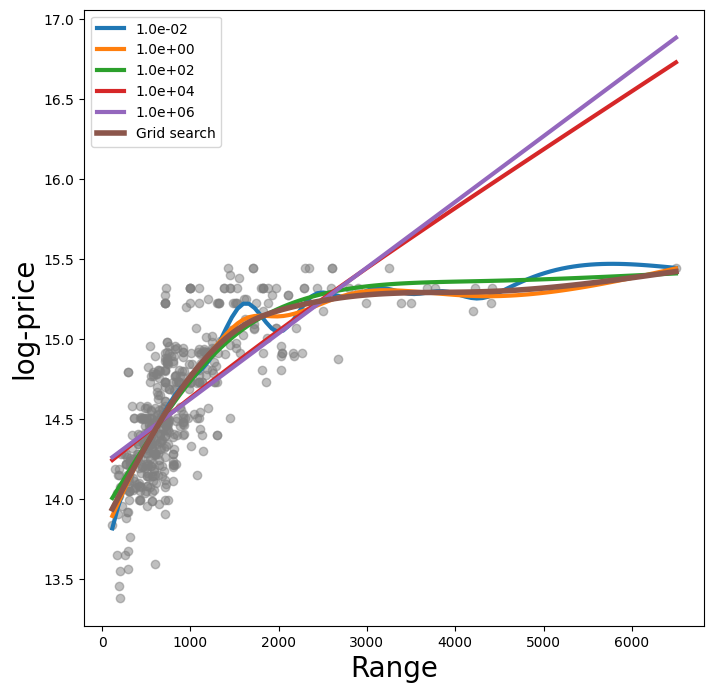

In [126]:
gam_opt = gam.gridsearch(X_range, y)
ax.plot(range_grid,
        gam_opt.predict(range_grid),
        label='Grid search',
        linewidth=4)
ax.legend()
fig

*GridSearch is the optimal smoothing parameter*

#### Alternative method (deegress of freedom)


In [127]:
range_term = gam.terms[0]
lam_4 = approx_lam(X_range, range_term, 4)
range_term.lam = lam_4

print(f"Degrees of freedom: {degrees_of_freedom(X_range, range_term)}")

Degrees of freedom: 1.9997562796104673


Skipping df=1 due to error: f(a) and f(b) must have different signs


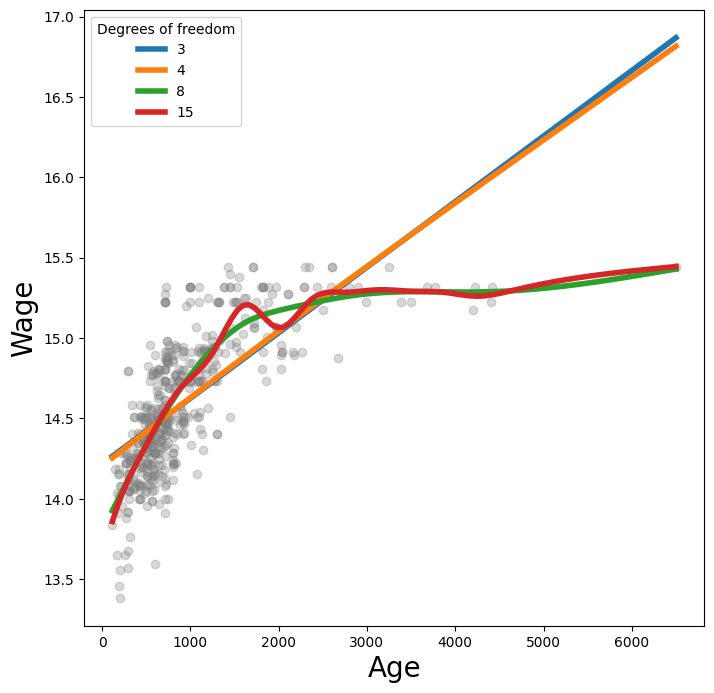

In [128]:
fig, ax = subplots(figsize=(8,8))
ax.scatter(X_range,
           y,
           facecolor='gray',
           alpha=0.3)
for df in [1, 3, 4, 8, 15]:
    try:
        lam = approx_lam(X_range, range_term, df + 1)
        range_term.lam = lam
        gam.fit(X_range, y)
        ax.plot(range_grid,
                gam.predict(range_grid),
                label='{:d}'.format(df),
                linewidth=4)
    except ValueError as e:
        print(f"Skipping df={df} due to error: {e}")
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='Degrees of freedom');

## Additive Models with Several Terms



In [129]:
data.columns

Index(['price', 'roc_mean', 'speed_margin', 'power_per_distance', 'wing_span',
       'range'],
      dtype='object')

In [130]:
gam_full = LinearGAM(s_gam(0) +
                     s_gam(1, n_splines=7) +
                     f_gam(2, lam=0))
Xgam = np.column_stack([range,
                        data['roc_mean'],
                        data['speed_margin'],
                        ])
gam_full = gam_full.fit(Xgam, y)

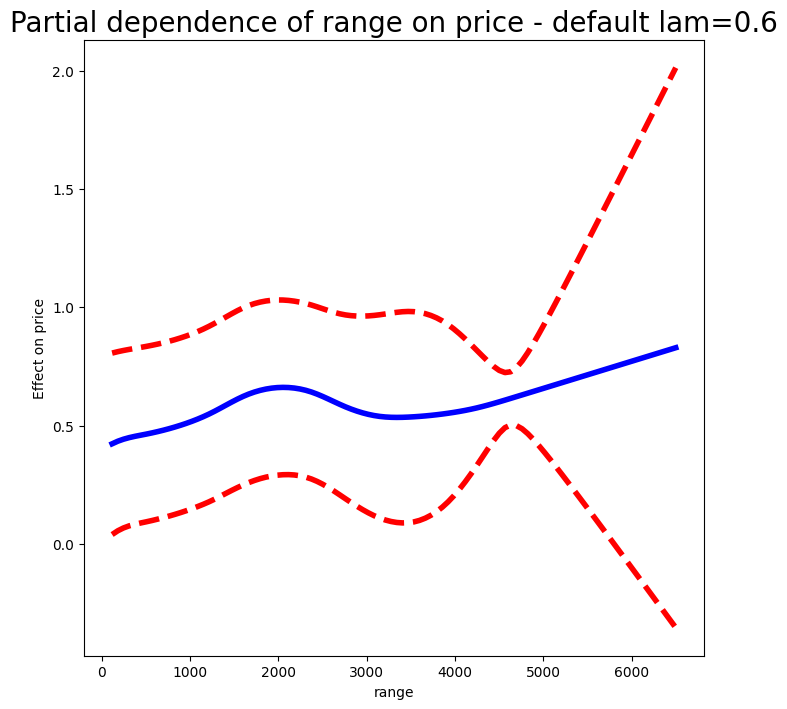

In [131]:
fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full, 0, ax=ax)
ax.set_xlabel('range')
ax.set_ylabel('Effect on price')
ax.set_title('Partial dependence of range on price - default lam=0.6', fontsize=20);

In [132]:
range_term = gam_full.terms[0]
range_term.lam = approx_lam(Xgam, range_term, df=4+1)
roc_mean_term = gam_full.terms[1]
roc_mean_term.lam = approx_lam(Xgam, roc_mean_term, df=4+1)
gam_full = gam_full.fit(Xgam, y)

Text(0.5, 1.0, 'Partial dependence of roc_mean on price')

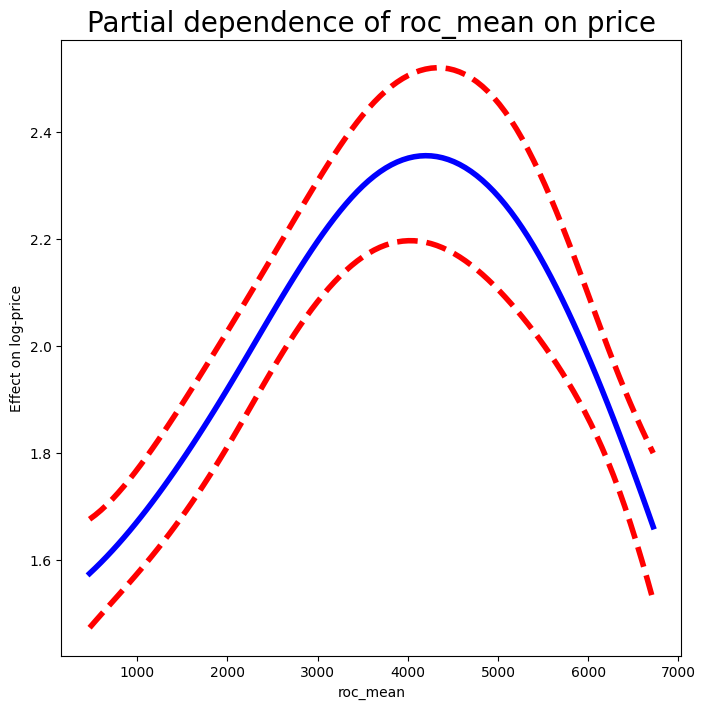

In [133]:
fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full,
         1,
         ax=ax)
ax.set_xlabel('roc_mean')
ax.set_ylabel('Effect on log-price')
ax.set_title('Partial dependence of roc_mean on price', fontsize=20)

In [134]:
from pygam import LinearGAM, s, f # s for splines, f for factors
import numpy as np

# X = tutte le variabili eccetto il target
X = data[['range', 'roc_mean', 'speed_margin', 'power_per_distance', 'wing_span']].values
y = data['price'].values


#### GAM model 

In [135]:
gam = LinearGAM(
    s(0) +               # range
    s(1) +               # roc_mean
    f(2) +               # speed_margin
    s(3) +               # power_per_distance
    s(4)                 # wing_span
)


#### Smoothing with grid search for lambda

In [136]:
gam.gridsearch(X, y)


  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:02 ETA:   0:00:22
 18% (2 of 11) |####                     | Elapsed Time: 0:00:04 ETA:   0:00:20
 27% (3 of 11) |######                   | Elapsed Time: 0:00:06 ETA:   0:00:16
 36% (4 of 11) |#########                | Elapsed Time: 0:00:08 ETA:   0:00:15
 45% (5 of 11) |###########              | Elapsed Time: 0:00:10 ETA:   0:00:12
 54% (6 of 11) |#############            | Elapsed Time: 0:00:12 ETA:   0:00:10
 63% (7 of 11) |###############          | Elapsed Time: 0:00:14 ETA:   0:00:08
 72% (8 of 11) |##################       | Elapsed Time: 0:00:16 ETA:   0:00:06
 81% (9 of 11) |####################     | Elapsed Time: 0:00:19 ETA:   0:00:04
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:21 ETA:   0:00:02
100% (11 of 11) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + f(2) + s(3) + s(4) + intercept, tol=0.0001, 
   verbose=False)

In [137]:
print(gam.summary())


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     63.8036
Link Function:                     IdentityLink Log Likelihood:                                 -6612.1024
Number of Samples:                          507 AIC:                                             13353.812
                                                AICc:                                           13373.1427
                                                GCV:                                                0.0358
                                                Scale:                                              0.0278
                                                Pseudo R-Squared:                                   0.8569
Feature Function                  Lam

/var/folders/r4/hh357kg10tl7tyxysctqkm100000gn/T/ipykernel_76719/1735839357.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pygam import LinearGAM, s, f

# 1) Definizione del target e dei predittori
y = data['price'].values
predictors = ['range', 'roc_mean', 'speed_margin', 'power_per_distance', 'wing_span']
X = data[predictors].to_numpy()

# 2) Costruzione del modello: spline per le variabili numeriche, fattoriale per speed_margin
gam = LinearGAM(
    s(0) +    # range
    s(1) +    # roc_mean
    f(2) +    # speed_margin (categorica)
    s(3) +    # power_per_distance
    s(4)      # wing_span
)

# 3) Ricerca automatica dei migliori λ (può richiedere qualche secondo)
gam.gridsearch(X, y)


# restituisce direttamente lo explained deviance come float
r2 = gam.score(X, y)
print(f"Pseudo-R²: {r2:.3f}")

#summary
print(gam.summary())






  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:02 ETA:   0:00:21
 18% (2 of 11) |####                     | Elapsed Time: 0:00:03 ETA:   0:00:17
 27% (3 of 11) |######                   | Elapsed Time: 0:00:06 ETA:   0:00:16
 36% (4 of 11) |#########                | Elapsed Time: 0:00:07 ETA:   0:00:13
 45% (5 of 11) |###########              | Elapsed Time: 0:00:09 ETA:   0:00:11
 54% (6 of 11) |#############            | Elapsed Time: 0:00:11 ETA:   0:00:09
 63% (7 of 11) |###############          | Elapsed Time: 0:00:13 ETA:   0:00:07
 72% (8 of 11) |##################       | Elapsed Time: 0:00:15 ETA:   0:00:05
 81% (9 of 11) |####################     | Elapsed Time: 0:00:17 ETA:   0:00:03
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:18 ETA:   0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:20 Time:  0:00:20


Pseudo-R²: 0.857
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     63.8036
Link Function:                     IdentityLink Log Likelihood:                                 -6612.1024
Number of Samples:                          507 AIC:                                             13353.812
                                                AICc:                                           13373.1427
                                                GCV:                                                0.0358
                                                Scale:                                              0.0278
                                                Pseudo R-Squared:                                   0.8569
Feature Function    

/var/folders/r4/hh357kg10tl7tyxysctqkm100000gn/T/ipykernel_76719/933844634.py:29: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


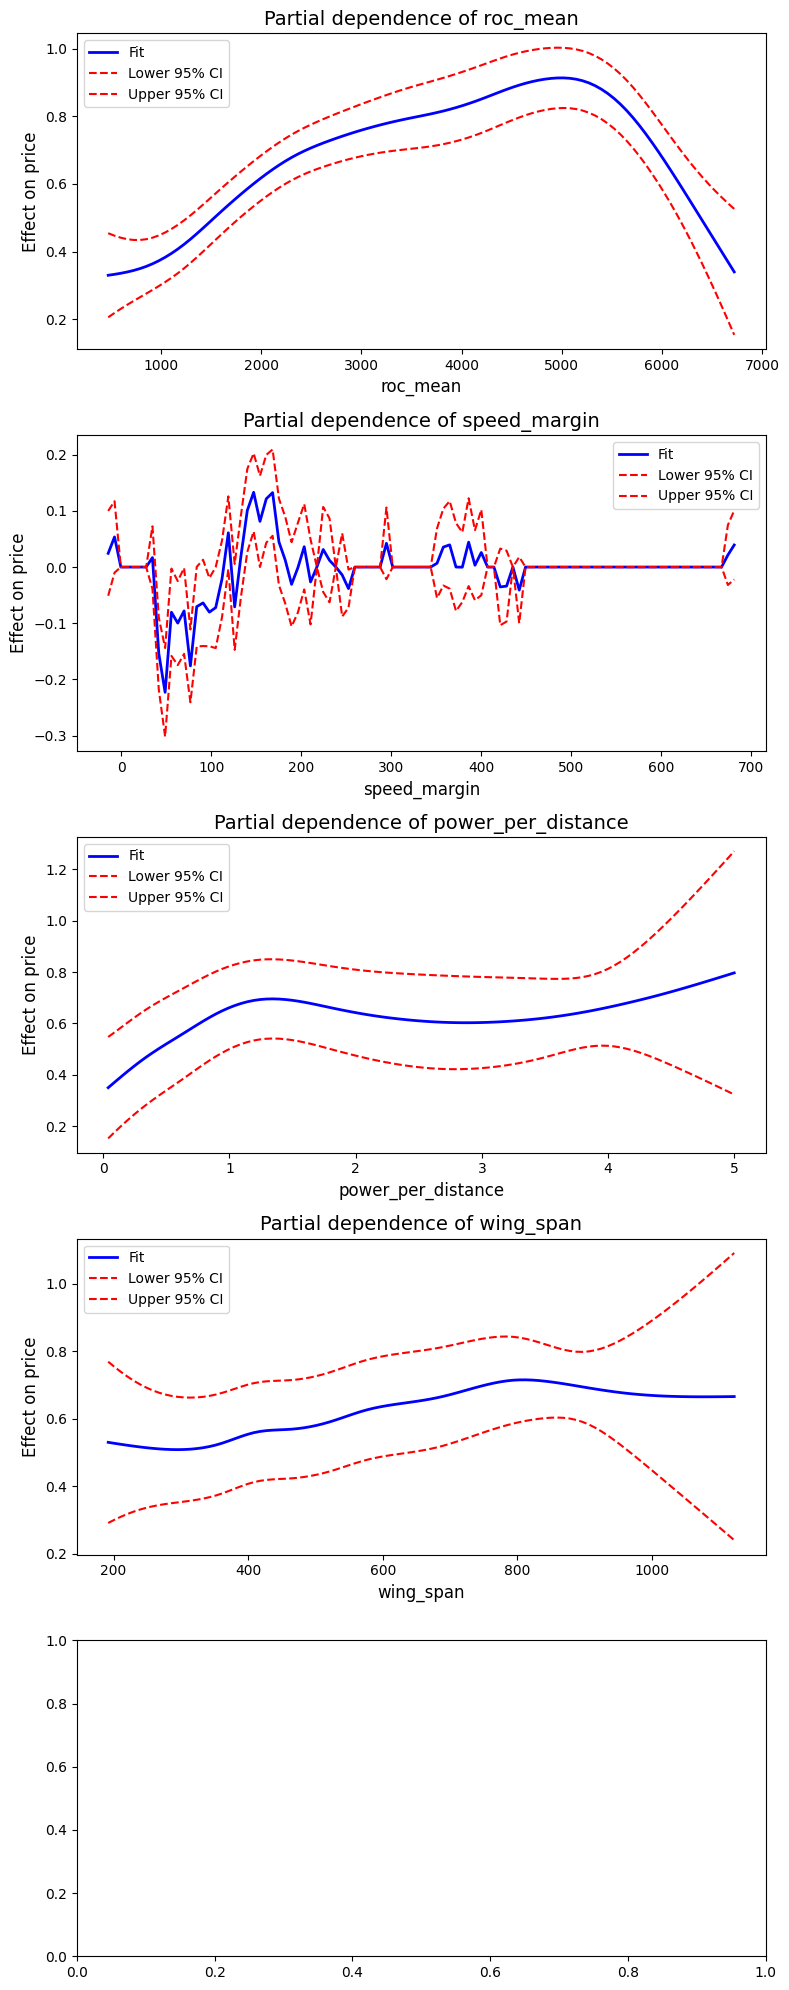

In [140]:
import matplotlib.pyplot as plt

# Your predictors, in the same order as the indices in the GAM terms
predictors = ['range', 'roc_mean', 'speed_margin', 'power_per_distance', 'wing_span']

# Number of non-intercept terms
n_terms = len(predictors)

fig, axes = plt.subplots(n_terms, 1, figsize=(8, 4 * n_terms))
for idx, var in enumerate(predictors, start=0):  # Start from 0 to match term indices
    if idx == 0:  # Skip the intercept term
        continue
    ax = axes[idx - 1]
    # Generate the grid for term idx (1…n_terms)
    XX = gam.generate_X_grid(term=idx)
    # Calculate partial dependence and confidence intervals
    pdep, confi = gam.partial_dependence(term=idx, X=XX, width=0.95)
    # The x-axis corresponds to the values of the variable
    xvals = XX[:, idx]

    ax.plot(xvals, pdep, 'b-', linewidth=2, label='Fit')
    ax.plot(xvals, confi[:, 0], 'r--', linewidth=1.5, label='Lower 95% CI')
    ax.plot(xvals, confi[:, 1], 'r--', linewidth=1.5, label='Upper 95% CI')
    ax.set_title(f'Partial dependence of {var}', fontsize=14)
    ax.set_xlabel(var, fontsize=12)
    ax.set_ylabel('Effect on price', fontsize=12)
    ax.legend()

plt.tight_layout()
plt.show()


Ecco un’interpretazione dei quattro partial-dependence plots che hai ottenuto (su `roc_mean`, `speed_margin`, `power_per_distance` e `wing_span`), tutti espressi come “effetto sul prezzo” a parità delle altre variabili:

---

### 1. `roc_mean`  
![roc_mean](attachment)  
- **Andamento monotono-convesso**: per valori bassi di `roc_mean` (300–1 500) l’effetto sul prezzo parte intorno a +0.3–0.4 e cresce in modo regolare.  
- **Punto di massima sensibilità** intorno a 4 000–5 000, dove l’effetto raggiunge quasi +0.9 sul prezzo (in scala logaritmica).  
- **Caduta rapida** oltre 6 000: sembra che un `roc_mean` troppo elevato riduca nuovamente l’effetto sul prezzo.  
- **Bande di confidenza** strette (rosse), quindi questa curva è stimata con buona precisione.

---

### 2. `speed_margin`  
![speed_margin](attachment)  
- **Effetto complessivamente vicino a zero**: la linea blu oscilla intorno allo 0, con variazioni fra –0.1 e +0.1.  
- **Ampiezza delle CI molto elevata**: le bande rosse sono larghe, segno di forte incertezza.  
- **Nessuna tendenza evidente**: non c’è un chiaro pattern crescente o decrescente.  
- **Conclusione**: `speed_margin` non sembra spiegare in modo significativo le variazioni di prezzo, oppure meriterebbe un’ulteriore codifica (magari trattarlo davvero da categorico con poche classi).

---

### 3. `power_per_distance`  
![power_per_distance](attachment)  
- **Crescita iniziale**: da 0 a ~1 l’effetto sale rapidamente da +0.35 a +0.7.  
- **Piccolo calo** attorno a 2–3 (effetto che scende vicino a +0.55–0.6).  
- **Ripresa finale** oltre 4, con l’effetto che risale verso +0.8 quando `power_per_distance` è massimo.  
- **Interpretazione**: un contributo complesso non-monotono: prezzi più alti sia per consumi estremamente bassi (efficienza alta) sia per consumi più alti, con un “minimo” intermedio.

---

### 4. `wing_span`  
![wing_span](attachment)  
- **Salita dolce** fra 200 e ~800: l’effetto sale da circa +0.5 a +0.75.  
- **Plateau/debole flessione** dopo 900–1 000, con l’effetto che si stabilizza intorno a +0.65–0.7 per alias di apertura molto grandi.  
- **Bande di confidenza moderate**: il fit è abbastanza certo, ma con un po’ di incertezza alle code.  
- **Interpretazione**: ali con apertura intermedia (intorno a 800) massimizzano il contributo al prezzo; aperture troppo piccole o troppo grandi riducono leggermente l’effetto.

---

## 💡 Conclusioni generali

- **`roc_mean`** è il predittore più forte e ben definito (curve liscia, CI strette).  
- **`speed_margin`** ha scarso potere esplicativo così com’è codificato.  
- **`power_per_distance`** e **`wing_span`** mostrano relazioni non monotone, indicando che l’effetto sul prezzo varia in modo non banale: in entrambi i casi esiste un “punto di massimo” nel mezzo del range.  

Se vuoi semplificare ulteriormente o migliorare l’accuratezza, potresti:
1. Ridurre il numero di spline per i termini con alta varianza (es. `speed_margin`).  
2. Rivedere la codifica di `speed_margin` (magari trasformarla in pochi gruppi).  
3. Raffinare i gradi di libertà (λ) tramite `gridsearch` o AIC.  

Fammi sapere se vuoi approfondire qualche aspetto in particolare!